<a href="https://colab.research.google.com/github/mpekar1/Citizenship-example/blob/main/Passport_prediction_hypthetical_scenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Introduction**

This demonstration explores a simple scenario involving two hypothetical countries, **Country A** and **Country B**, to model and predict future citizenship applications. In these countries:

- Individuals first apply for **residency** and, upon approval, must wait a specific number of years before becoming eligible to apply for **citizenship**.
- The waiting period varies across applicants, with typical delays being **5 years for Country A** and **7 years for Country B**, but with variability.

#### **The dataset includes fake data**:
1. **Successful residency applications** from 2014 to 2024, with a peak in 2021 reflecting an unusual event (e.g., policy changes or a pandemic).
2. **Observed citizenship applications** from 2014 to 2024, derived from the historical residency data.

#### **Purpose of the demonstration**
The purpose of this demonstration is to compare two modeling approaches:
1. A **Monte Carlo (MC) model** that incorporates stochasticity and empirically-derived distributions of delays.
2. A **contender median model** that uses deterministic median delays to predict citizenship applications.

Both models rely solely on past successful residency applications without attempting to forecast future residency numbers. This provides a simplified yet robust example of how Monte Carlo simulations can be applied and validated against a deterministic approach.


### **Description of the code**

This code implements and validates two models (Monte Carlo and Median) to predict total citizenship applications for the validation years (2021–2024). The predictions are compared to observed data using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**, which are standard metrics for model evaluation.

#### **Key concepts and approach**

1. **Validation approach**:
   - The **validation period** (2021–2024) predictions are based only on information available during the **training period** (2014–2020).
   - For example, the distribution of delays between residency and citizenship applications is computed using residency cohorts observed only up to the first validation year (2021). This prevents **data leakage** and ensures the model generalises well.

2. **Monte Carlo model**:
   - This approach uses stochastic sampling based on an empirical delay distribution to simulate citizenship applications for eligible residency cohorts.
   - The delay distribution is derived from known residency data from the training period.

3. **Median model**:
   - A simpler deterministic model where the median delay (5 years for Country A, 7 years for Country B) is applied to predict the total citizenship applications from eligible cohorts.

4. **Goodness of Fit metrics**:
   - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors between predicted and observed values.
     $$
     \text{MAE} = \frac{1}{n} \sum_{i=1}^n \left| y_i - \hat{y}_i \right|
     $$
   - **Root Mean Squared Error (RMSE)**: Penalizes larger errors more heavily by squaring the differences between predicted and observed values.
     $$
     \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2}
     $$

Where:

- $y_i$ is the actual value.
- $\hat{y}_i$ is the predicted value.
- $n$ is the total number of data points.

These metrics provide insight into the model's accuracy, with lower values indicating better performance. MAE provides an interpretable average error, while RMSE emphasises larger deviations.

5. **Visualisation**:
   - The results are plotted to compare observed citizenship applications with predictions from the Monte Carlo and median models, allowing for an intuitive/visual performance assessment.


Step 1: Set up, generate some toy numbers



In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Residency application data (2014-2024) with a peak in 2021
years = np.arange(2014, 2025)
residency_applications_A = [500, 520, 530, 550, 570, 600, 620, 1000, 900, 750, 600]
residency_applications_B = [300, 320, 340, 350, 370, 400, 420, 900, 850, 700, 450]

data = pd.DataFrame({
    'year': years,
    'Country_A': residency_applications_A,
    'Country_B': residency_applications_B
})

# Display the data
print(data)


    year  Country_A  Country_B
0   2014        500        300
1   2015        520        320
2   2016        530        340
3   2017        550        350
4   2018        570        370
5   2019        600        400
6   2020        620        420
7   2021       1000        900
8   2022        900        850
9   2023        750        700
10  2024        600        450


Generate some citizenships applications data, make a peak at 2021

In [53]:
# Parameters for stochastic citizenship application delays
np.random.seed(42)  # For reproducibility
base_delay_A = 5  # Median delay for Country A
base_delay_B = 7  # Median delay for Country B

# Generate observed citizenship applications
observed_citizenship = pd.DataFrame({'year': data['year']})

# Function to calculate citizenship applications with stochasticity
def generate_citizenship_applications(residency_data, base_delay, covid_peak_year=2021, covid_multiplier=2):
    applications = np.zeros(len(residency_data))
    for i, year in enumerate(residency_data['year']):
        # Calculate eligible residency cohort
        eligible_residents = residency_data[residency_data['year'] <= year - base_delay]
        # Add stochastic delay to each eligible cohort
        cohort_applications = []
        for _, row in eligible_residents.iterrows():
            stochastic_delay = np.random.normal(loc=base_delay, scale=2, size=int(row[1]))
            citizenship_years = (row['year'] + stochastic_delay).astype(int)
            cohort_applications.append(np.sum(citizenship_years == year))
        applications[i] = np.sum(cohort_applications)
        # Add a COVID peak multiplier
        if year == covid_peak_year:
            applications[i] *= covid_multiplier
    return applications

# Generate observed citizenship applications for both countries
observed_citizenship['Country_A'] = generate_citizenship_applications(data, base_delay_A)
observed_citizenship['Country_B'] = generate_citizenship_applications(data, base_delay_B)

# Add totals for both countries
observed_citizenship['Total'] = observed_citizenship['Country_A'] + observed_citizenship['Country_B']

# Display observed data
print(observed_citizenship)


    year  Country_A  Country_B  Total
0   2014        0.0        0.0    0.0
1   2015        0.0        0.0    0.0
2   2016        0.0        0.0    0.0
3   2017        0.0        0.0    0.0
4   2018        0.0        0.0    0.0
5   2019      102.0        0.0  102.0
6   2020      172.0        0.0  172.0
7   2021      484.0      188.0  672.0
8   2022      262.0      171.0  433.0
9   2023      268.0      225.0  493.0
10  2024      281.0      237.0  518.0


<ipython-input-53-e5720331e6ea>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stochastic_delay = np.random.normal(loc=base_delay, scale=2, size=int(row[1]))
<ipython-input-53-e5720331e6ea>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stochastic_delay = np.random.normal(loc=base_delay, scale=2, size=int(row[1]))


Step 2: Empirical Distribution for Monte Carlo Simulation
python

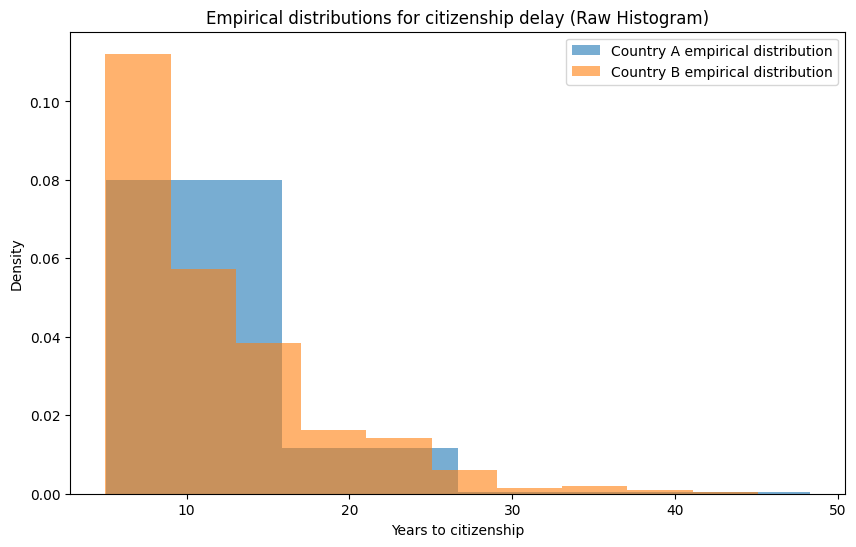

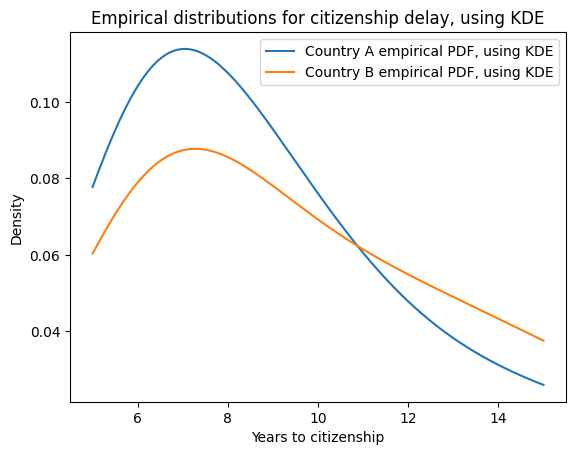

In [64]:
# Create empirical distributions for residency-to-citizenship delay
# For Country A
delay_A = np.random.exponential(scale=5, size=1000)  # Messy distribution centered around 5 years
delay_A = delay_A[delay_A >= 5]  # Minimum residency requirement

# For Country B
delay_B = np.random.exponential(scale=7, size=1000)
delay_B = delay_B[delay_B >= 5]

# Plot raw histograms for the empirical distributions
plt.figure(figsize=(10, 6))

# Histogram for Country A
plt.hist(delay_A, bins=4, alpha=0.6, label="Country A empirical distribution", density=True)

# Histogram for Country B
plt.hist(delay_B, bins=10, alpha=0.6, label="Country B empirical distribution", density=True)

# Adding labels and legend
plt.title("Empirical distributions for citizenship delay (Raw Histogram)")
plt.xlabel("Years to citizenship")
plt.ylabel("Density")
plt.legend()
plt.show()

# KDE for empirical PDFs. KDE is a non-parametric way to estimate the probability density
# function. It smooths the observed delays into a continuous curve, better
# reflecting real-world data than a simple histogram.

kde_A = gaussian_kde(delay_A)
kde_B = gaussian_kde(delay_B)

# Visualize the distributions
x = np.linspace(5, 15, 500)
plt.plot(x, kde_A(x), label="Country A empirical PDF, using KDE")
plt.plot(x, kde_B(x), label="Country B empirical PDF, using KDE")
plt.title("Empirical distributions for citizenship delay, using KDE")
plt.xlabel("Years to citizenship")
plt.ylabel("Density")
plt.legend()
plt.show()


Step 3: MC simulation

In [65]:
# Monte Carlo simulation to predict citizenship applications (2024-2029)
future_years = np.arange(2024, 2029)
simulated_citizenship_A = []
simulated_citizenship_B = []

for year in future_years:
    # Country A
    eligible_residents_A = data[data['year'] <= year - 5]['Country_A']
    total_citizenship_A = 0
    for i, residency in enumerate(eligible_residents_A):
        sampled_delays = kde_A.resample(residency).flatten()
        citizenship_years = (data['year'].iloc[i] + sampled_delays).astype(int)
        total_citizenship_A += np.sum(citizenship_years == year)
    simulated_citizenship_A.append(total_citizenship_A)

    # Country B
    eligible_residents_B = data[data['year'] <= year - 5]['Country_B']
    total_citizenship_B = 0
    for i, residency in enumerate(eligible_residents_B):
        sampled_delays = kde_B.resample(residency).flatten()
        citizenship_years = (data['year'].iloc[i] + sampled_delays).astype(int)
        total_citizenship_B += np.sum(citizenship_years == year)
    simulated_citizenship_B.append(total_citizenship_B)

# Combine results
future_citizenship_mc = pd.DataFrame({
    'year': future_years,
    'Country_A': simulated_citizenship_A,
    'Country_B': simulated_citizenship_B
})

print(future_citizenship_mc)


   year  Country_A  Country_B
0  2024        305        156
1  2025        349        220
2  2026        424        264
3  2027        448        270
4  2028        502        350


Step 4: Contender model: using median year

In [56]:
# Contender model: simple delay using median delays
median_delay_A = 5
median_delay_B = 7

future_citizenship_median = pd.DataFrame({
    'year': future_years,
    'Country_A': [data[data['year'] == year - median_delay_A]['Country_A'].sum() for year in future_years],
    'Country_B': [data[data['year'] == year - median_delay_B]['Country_B'].sum() for year in future_years]
})

print(future_citizenship_median)


   year  Country_A  Country_B
0  2024        600        350
1  2025        620        370
2  2026       1000        400
3  2027        900        420
4  2028        750        900


Step 5: Validation and Goodness-of-Fit

Adjust Validation Period Predictions

In [66]:
# Monte Carlo Model
validation_mc_total = []

for year in validation_years:
    # Calculate citizenship applications for Country A
    eligible_residents_A = data[data['year'] <= year - base_delay_A]['Country_A']
    mc_A = 0
    for i, residency in enumerate(eligible_residents_A):
        # Sample delays from the empirical distribution (delay_A)
        sampled_delays = np.random.choice(delay_A, size=residency)
        citizenship_years = (data['year'].iloc[i] + sampled_delays).astype(int)
        mc_A += np.sum(citizenship_years == year)

    # Calculate citizenship applications for Country B
    eligible_residents_B = data[data['year'] <= year - base_delay_B]['Country_B']
    mc_B = 0
    for i, residency in enumerate(eligible_residents_B):
        # Sample delays from the empirical distribution (delay_B)
        sampled_delays = np.random.choice(delay_B, size=residency)
        citizenship_years = (data['year'].iloc[i] + sampled_delays).astype(int)
        mc_B += np.sum(citizenship_years == year)

    # Append total for both countries
    validation_mc_total.append(mc_A + mc_B)


# Median Model
validation_median_total = []

for year in validation_years:
    # Citizenship applications based on median delays
    median_A = data[data['year'] == year - base_delay_A]['Country_A'].sum()
    median_B = data[data['year'] == year - base_delay_B]['Country_B'].sum()
    validation_median_total.append(median_A + median_B)

# Combine into a DataFrame
validation_predictions = pd.DataFrame({
    'Year': validation_years,
    'Observed_Total': observed_citizenship[observed_citizenship['year'].isin(validation_years)]['Total'].values,
    'Monte_Carlo_Total': validation_mc_total,
    'Median_Total': validation_median_total
})

# Display the predictions
print(validation_predictions)


   Year  Observed_Total  Monte_Carlo_Total  Median_Total
0  2021           672.0                261           830
1  2022           433.0                347           870
2  2023           493.0                405           910
3  2024           518.0                472           950


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract columns for metrics
observed = validation_predictions['Observed_Total']
mc_predicted = validation_predictions['Monte_Carlo_Total']
median_predicted = validation_predictions['Median_Total']

# Compute metrics
mae_mc = mean_absolute_error(observed, mc_predicted)
rmse_mc = np.sqrt(mean_squared_error(observed, mc_predicted))

mae_median = mean_absolute_error(observed, median_predicted)
rmse_median = np.sqrt(mean_squared_error(observed, median_predicted))

print(f"Monte Carlo Model - MAE: {mae_mc:.2f}, RMSE: {rmse_mc:.2f}")
print(f"Median Model - MAE: {mae_median:.2f}, RMSE: {rmse_median:.2f}")



Monte Carlo Model - MAE: 157.75, RMSE: 215.74
Median Model - MAE: 361.00, RMSE: 379.62


Create a graph showing observed values and predictions for total citizenship applications (Country A + Country B)

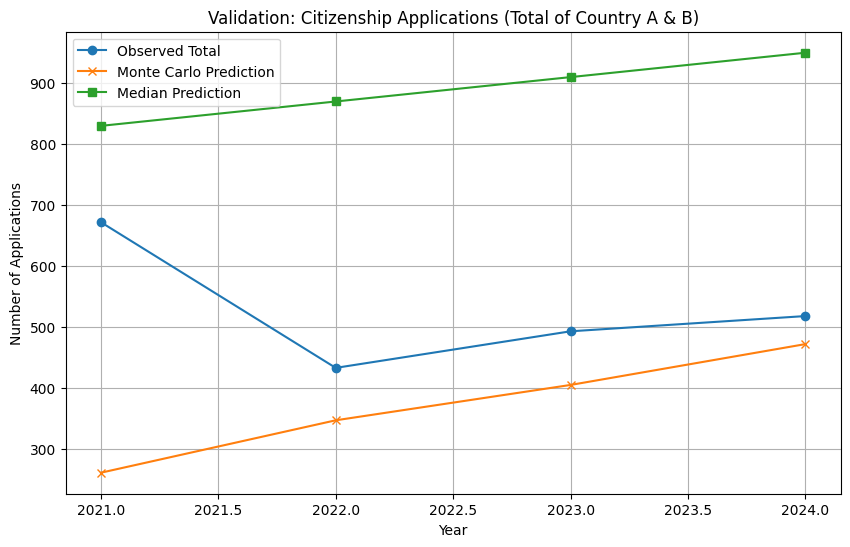

In [68]:
# Plot observed vs predictions
plt.figure(figsize=(10, 6))
plt.plot(validation_predictions['Year'], validation_predictions['Observed_Total'], label='Observed Total', marker='o')
plt.plot(validation_predictions['Year'], validation_predictions['Monte_Carlo_Total'], label='Monte Carlo Prediction', marker='x')
plt.plot(validation_predictions['Year'], validation_predictions['Median_Total'], label='Median Prediction', marker='s')
plt.title("Validation: Citizenship Applications (Total of Country A & B)")
plt.xlabel("Year")
plt.ylabel("Number of Applications")
plt.legend()
plt.grid()
plt.show()




Comprehensive visualisation

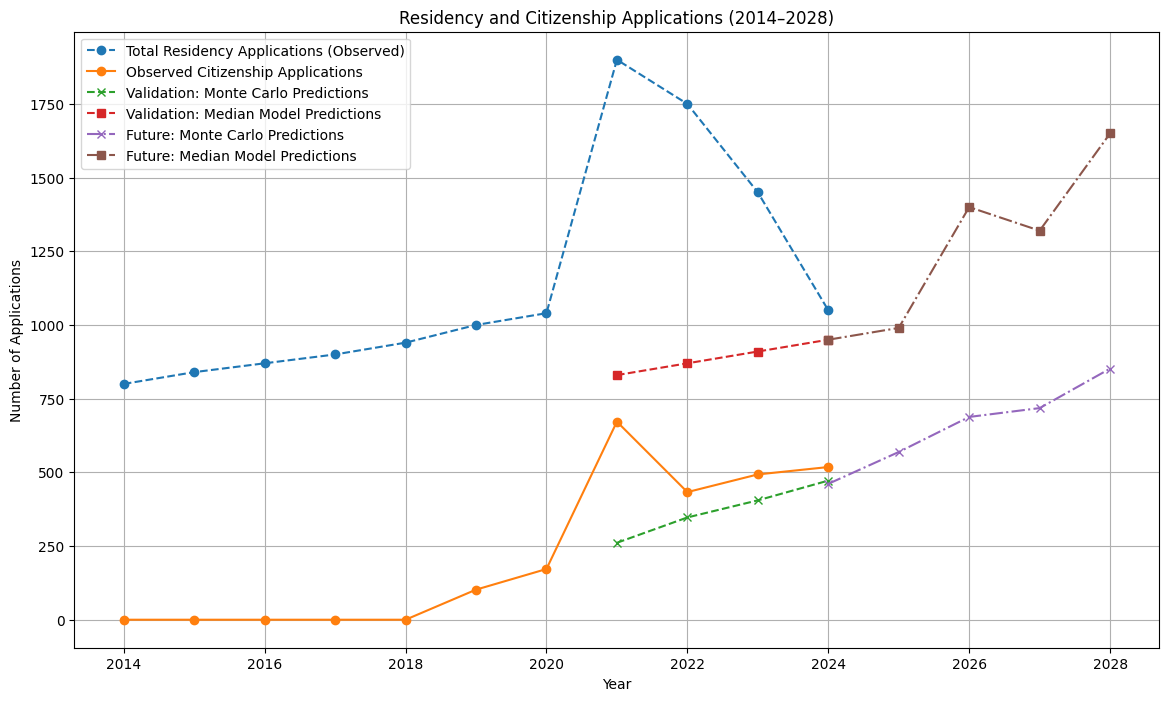

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for plotting
full_years = np.arange(2014, 2029)

# Residency applications: sum of Country A and Country B
residency_total = data['Country_A'] + data['Country_B']

# Observed citizenship applications
citizenship_total_observed = observed_citizenship['Total']

# Validation Monte Carlo predictions
validation_years = validation_predictions['Year']
validation_mc = validation_predictions['Monte_Carlo_Total']
validation_median = validation_predictions['Median_Total']

# Future predictions: Monte Carlo
future_years_mc = future_citizenship_mc['year']
future_mc = future_citizenship_mc['Country_A'] + future_citizenship_mc['Country_B']

# Future predictions: Median
future_years_median = future_citizenship_median['year']
future_median = future_citizenship_median['Country_A'] + future_citizenship_median['Country_B']

# Plot residency applications
plt.figure(figsize=(14, 8))
plt.plot(data['year'], residency_total, label="Total Residency Applications (Observed)", linestyle='--', marker='o')

# Plot observed citizenship applications
plt.plot(observed_citizenship['year'], citizenship_total_observed, label="Observed Citizenship Applications", marker='o')

# Plot validation predictions
plt.plot(validation_years, validation_mc, label="Validation: Monte Carlo Predictions", linestyle='--', marker='x')
plt.plot(validation_years, validation_median, label="Validation: Median Model Predictions", linestyle='--', marker='s')

# Plot future predictions
plt.plot(future_years_mc, future_mc, label="Future: Monte Carlo Predictions", linestyle='-.', marker='x')
plt.plot(future_years_median, future_median, label="Future: Median Model Predictions", linestyle='-.', marker='s')

# Add titles and labels
plt.title("Residency and Citizenship Applications (2014–2028)")
plt.xlabel("Year")
plt.ylabel("Number of Applications")
plt.legend()
plt.grid()

# Display the plot
plt.show()


